In [49]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19


In [50]:
# base_image_path = keras.utils.get_file("paris.jpg", "https://i.imgur.com/F28w3Ac.jpg")
# style_reference_image_path = keras.utils.get_file(
#     "starry_night.jpg", "https://i.imgur.com/9ooB60I.jpg"
# )
# result_prefix = "paris_generated"


In [55]:
base_image_path = "sourav.jpg"
style_reference_image_path = "508581.png"
result_prefix = "VanG_generated"


In [56]:
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8


In [57]:
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

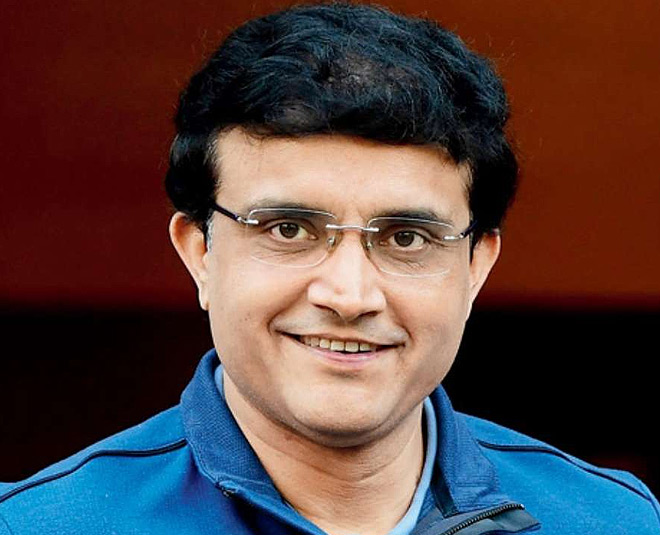

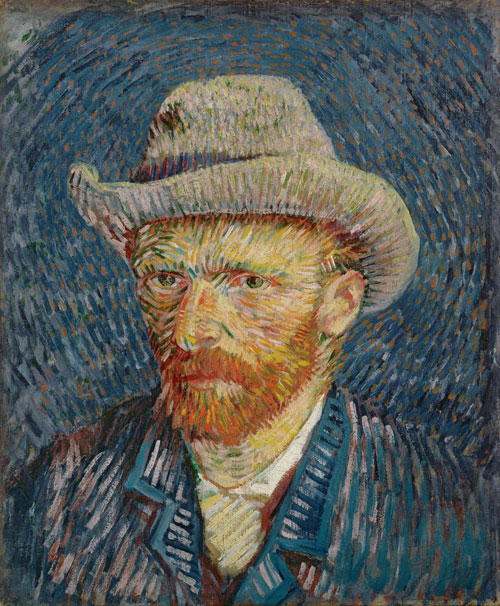

In [58]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_reference_image_path))


In [59]:

def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x



def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))



In [60]:


model = vgg19.VGG19(weights="imagenet", include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)




In [61]:

style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss


In [62]:

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads


In [63]:

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))


In [64]:
iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)


Iteration 100: loss=1561.42
Iteration 200: loss=1220.58
Iteration 300: loss=1070.22
Iteration 400: loss=982.53
Iteration 500: loss=924.01
Iteration 600: loss=881.65
Iteration 700: loss=849.34
Iteration 800: loss=823.75
Iteration 900: loss=802.81
Iteration 1000: loss=785.34
Iteration 1100: loss=770.51
Iteration 1200: loss=757.75
Iteration 1300: loss=746.66
Iteration 1400: loss=736.94
Iteration 1500: loss=728.34
Iteration 1600: loss=720.67
Iteration 1700: loss=713.79
Iteration 1800: loss=707.57
Iteration 1900: loss=701.94
Iteration 2000: loss=696.81
Iteration 2100: loss=692.11
Iteration 2200: loss=687.80
Iteration 2300: loss=683.83
Iteration 2400: loss=680.17
Iteration 2500: loss=676.78
Iteration 2600: loss=673.64
Iteration 2700: loss=670.72
Iteration 2800: loss=668.01
Iteration 2900: loss=665.48
Iteration 3000: loss=663.11
Iteration 3100: loss=660.89
Iteration 3200: loss=658.82
Iteration 3300: loss=656.88
Iteration 3400: loss=655.05
Iteration 3500: loss=653.33
Iteration 3600: loss=651.7

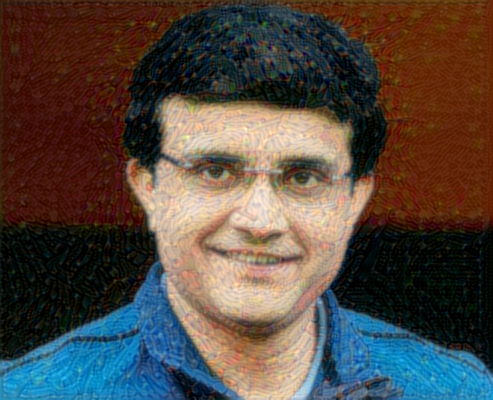

In [65]:
display(Image(result_prefix + "_at_iteration_4000.png"))

In [ ]:
keras.preprocessing.image.save_img(fname, img)